# Music and the Homo/Heterogenization of Culture

In "The Culture Industry: Enlightenment as Mass Deceoption", Horkheimer and Adorno claim that "Culture today is infecting everything with sameness". <br>
They argue that while variations do exist, the variation is not true variation -- rather, like a wheel spinning in place, it gives the appearance of differentiation, but there ultimately is no true difference. Either the differences are surface level (such as the extravagant use of technology in films) and do not relate to the meaning of the products themselves, or they do not varying from existing styles. Everything is created within the same pre-existing types. <br>
<br>
Here, we will evaluate this claim of "sameness" in relation to the popular music industry, using data from the Billboard Hot 100.

In [1]:
import importlib
# import access
# from access import *
# importlib.reload(access)

import music
# importlib.reload(music)

C:\Users\grace\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
# ! pip install librosa --quiet
import numpy as np
import pandas as pd

import json
import datetime

import matplotlib.pyplot as plt
# from IPython.display import Audio, display
# import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12})
import altair as alt

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import nltk
import string
from gensim import corpora, models
# import pyLDAvis
# import pyLDAvis.gensim_models

import warnings
warnings.simplefilter(action='ignore')

# I. Read in data

In [6]:
#| include: true
#| eval: true
music_df = pd.read_csv('pt1_files\music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)
print(music_df.columns)
music_df.head(2)

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender'],
      dtype='object')


,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,...,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group


In [7]:
f = open('pt1_files\directdata.json')
direct_list = eval(f.read())
f.close()
direct_dict = {}
for i in range(len(direct_list)):
    direct_dict[direct_list[i]['year']] = pd.json_normalize(direct_list[i]['songs'])
direct_df = direct_dict[1950]
direct_df['year'] = 1950
for i in range(1951, 2016):
    direct_dict[i]['year'] = i
    direct_df = pd.concat([direct_df,direct_dict[i]])

In [8]:
# getting position of song in top 100
# and getting tags for each song
music_df = music_df.rename(columns={'pos': 'pos_sentiment', 'neg': 'neg_sentiment', 'neu': 'neu_sentiment'})

direct_df = direct_df.set_index(['year','artist','title'])[['pos','tags']]
music_df = music_df.set_index(['year','artist','title'])
music_df = pd.merge(music_df,direct_df[['pos','tags']],how='left',left_index=True,right_index=True).reset_index()

In [9]:
numerical = ['difficult_words','num_words','num_dupes',
'num_lines','duration_ms',
'fog_index','f_k_grade','flesch_index',
'speechiness','acousticness','instrumentalness',
'tempo','liveness','energy','danceability','loudness',
'pos_sentiment','neg_sentiment','neu_sentiment']
numerical_group = {'num_words':'words','num_dupes':'words','difficult_words':'words',
                    'num_lines':'length','duration_ms':'length',
                   'fog_index':'readability','f_k_grade':'readability','flesch_index':'readability',
                    'speechiness':'audio','acousticness':'audio','instrumentalness':'audio','tempo':'audio','liveness':'audio','energy':'audio','danceability':'audio','loudness':'audio',
                    'neg_sentiment':'sentiment','neu_sentiment':'sentiment','pos_sentiment':'sentiment'}
numerical = list(numerical)

In [12]:
standardized = music_df.copy()
standardized[numerical] = StandardScaler().fit_transform(music_df[numerical])

# II. Has our taste changed?

In [10]:
music_df_valid = music_df.dropna(subset=numerical)
X = music_df_valid[numerical]
y = music_df_valid['year']

# standardizing the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# apply pca
pca = PCA(0.95)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
print(sum(pca.explained_variance_ratio_[:3]))
print(pca.n_components_)

pcs = pca.transform(X)
music_pca = music_df_valid.copy()
for i in range(pca.n_components_):
    music_pca[f'pc{i}'] = pcs[:,i]
# reconstructed = pca.inverse_transform(pcs)

0.9576717322497605
0.43801138945960705
13


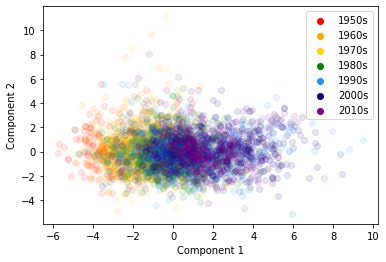

In [11]:
#| include: true
yearbin_colors = ['red','orange','gold','green','dodgerblue','navy','purple']
c = 0
plt.figure(figsize=(6,4))
for year in music_pca['year_bin'].unique():
    plt.scatter(music_pca[music_pca['year_bin']==year]['pc0'], music_pca[music_pca['year_bin']==year]['pc1'], alpha=0.1, label=year,
    c=yearbin_colors[c])
    c += 1
leg = plt.legend()
music.set_legend_alpha(leg.legendHandles)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.savefig('pca.png')

*Songs by Year*<br>
In this scatterplot, we have the first two components of a PCA decomposition of the Spotify numerical data (such as danceability, tempo, and speechiness) for each song on the Billboard Hot 100. The decade of release is represented by color. The years seem to be clustered, moving to the right with time.

There has been a general shift in our music taste over time. However, PCA decomposition loses interpretability. While Horkheimer and Adorno might argue that readability or acousticness do not capture the true content of music, I would argue that they do. The medium of music inherently communicates not only through lyrics, but also through the energy embedded in qualities such as acousticness. Thus, because the linear combination of these variables shows change over time, we start with the idea that Horkheimer and Adorno were not completely right.


### III. Are there big hits that are imitated after?

Horkheimer and Adorno argue that culture tends toward sameness through imitating what has previously demonstrated success. Therefore, songs that are different but successful should have many imitators. <br>
To see if this is true, I take the first ten years in the dataset and use their numerical metrics and PCA decomposition to create a basis that captures at least 95% of the information. From there, I find if there's a song in the next year's top ten whos residual is an outlier. Then, I repeat this for the next year, using all the previous years numerical values to create a new basis. <br>

90th percentile = 1.4620211499101512


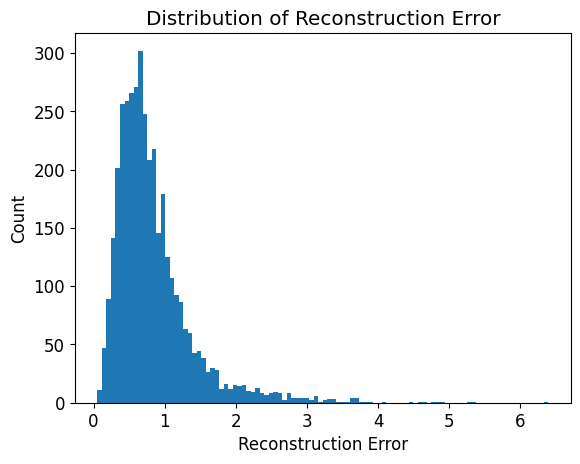

In [15]:
# build a PCA for the past years, find a song whos vector does not fit well into the existing PCA
all_reconstruct_err = []
for i in range(1960, 2015+1): # need ten years to start w
    past_df = standardized[['year','pos']+numerical].query('year < @i')
    pca = PCA(0.95)
    pca.fit(past_df[numerical])
    # print(i, sum(pca.explained_variance_ratio_), pca.n_components_)

    current_df = standardized.query('year == @i')
    current_pca = pca.transform(current_df[numerical])
    current_reconstruct = pca.inverse_transform(current_pca)
    current_reconstruct_err = np.linalg.norm(current_df[numerical] - current_reconstruct, axis=1)
    all_reconstruct_err.extend(current_reconstruct_err)
# find what residuals stand out
plt.hist(all_reconstruct_err, bins=100)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Error')
print(f'90th percentile = {np.percentile(all_reconstruct_err, 90)}')

In [16]:
standardized['reconstruct_err'] = [0]*len(standardized.query('year < 1960')) + all_reconstruct_err
unique = standardized.query('reconstruct_err >= 2').query('pos < 10')

In [17]:
# find the songs with highest cosine similarity to the unique songs
compare = standardized[~standardized.index.isin(unique.index)].copy()
for i in unique.index:
    compare['similarity_'+str(i)] = cosine_similarity(compare[numerical], unique.loc[i,numerical].values.reshape(1,-1)).flatten()

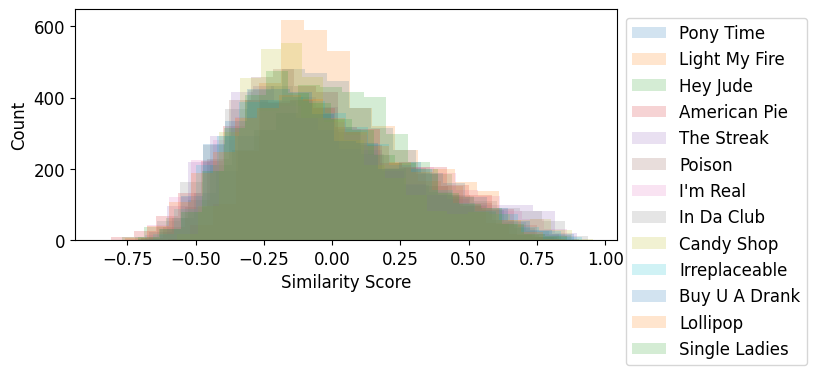

In [18]:
#| include: true
# find threshold for similarity
infl_5pct = {}
plt.figure(figsize=(7,3))
for i in unique.index:
    plt.hist(compare['similarity_'+str(i)], bins=20, alpha = 0.2, label = unique.loc[i,'title'])
    infl_5pct[i] = np.percentile(compare['similarity_'+str(i)], 95)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.show()

*PCA reconstruction residuals.* <br>
This histogram shows how similar each song is to each song unique for it's time. The distribution is mound shaped, and skewed to the right. Most songs are not similar to these unique songs, but a few are.

In [19]:
influenced = {}
for i in unique.index:
    influenced[i] = compare.query(f'similarity_{i} > 0.5')
    # print(len(influenced[i]))

In [27]:
all_influenced = pd.DataFrame(columns=['year','artist','title','similarity'])
for song in influenced.keys():
    df = influenced[song][['year','artist','title','pos',f'similarity_{song}']]\
        .rename(columns={f'similarity_{song}':'similarity','pos':'position'})
    df['Influencer'] = unique.loc[song]['title']
    df['Year Inspired'] = unique.loc[song]['year']
    all_influenced = pd.concat([all_influenced,df])

In [28]:
# convert year to datetime
all_influenced['year'] = all_influenced['year'].apply(lambda x: datetime.datetime.strptime(str(x),"%Y"))
all_influenced['Year Inspired'] = all_influenced['Year Inspired'].apply(lambda x: datetime.datetime.strptime(str(int(x)),"%Y"))

In [29]:
#| include: true
dots = alt.Chart(all_influenced).mark_point().encode(
    x = alt.X('year:T',scale=alt.Scale(zero=False),axis=alt.Axis(title='Year of Release')),
    y= alt.X(f'similarity',scale=alt.Scale(zero=False, domain=[0.5,1]),axis=alt.Axis(title='Similarity Score')),
#     facet=alt.Facet('Influencer:N'),
    tooltip = alt.Tooltip(['title','artist','position'])
).properties(
    width=170,
    height=170
)
release = alt.Chart(all_influenced).mark_rule(color='red').encode(
    x = alt.X('Year Inspired:T',axis=alt.Axis(title='Year of Release'))
).properties(
    width=170,
    height=170
)

infl_plots = dots+release

alt.ConcatChart(
    concat=[
      infl_plots.transform_filter(alt.datum.Influencer == value).properties(title=f'{value}')
      for value in sorted(all_influenced.Influencer.unique())
    ],
    columns=4
).configure_title(
    fontSize=20,
    anchor='middle',
    align='left'
# ).resolve_axis(
#     x='independent',
#     y='independent'
# ).resolve_scale(
#     x='independent', 
#     y='independent'
)

alt.ConcatChart(...)

*Influential vs. Influenced Songs.*<br>
These scatterplots show the most unique songs of their time, along with similar songs and their release year. The release year of the unique song is represented with a red line. "Poison" most clearly demonstrates imitators. "I'm Real" seems to be following a growing trend, and popularized said trend. Others, such as "Buy U A Drank", "Candy Shop", and "Single Ladies" seem to be following a trend, and happened to be the first song to reach the top 10. Still others, such as "The Streak" and "Hey Jude" seem to come before their time, with a different song later on setting the trend off.

From this, it seems that Horkheimer's argument that unique and successful songs create imitators is true. Each dot in these scatterplots have reached the Billboard Hot 100, so while the songs chosen (from the Top 10) might not have been the trendsetter, many of these plots show the emergence of a unique musical idea that then becomes common.<br>
<br>
A further analysis might identify the true trendsetters.<br>

### IV. Are genres becoming more standarized?

Horkheimer and Adorno argue that the mechanically differentiated products are alike in the end because they are created from formulas, proved to be successful. If that is the case, then the deviation from accepted norms should grow smaller as time goes on. <br>

With music, the accepted norms are the genres. Therefore, I'll examine the deviation within genres.

In [123]:
# organizing by year

In [124]:
helper_df = music_df.copy().dropna(subset=['tags'])
helper_df['words_per_line'] = helper_df['num_words'] / helper_df['num_lines']
# helper_df['wpm'] = helper_df['num_words'] / (helper_df['duration_ms']/60000) # not many songs have data for both variables
helper_df_standarized = helper_df.copy()

In [125]:
vars_words = ['words_per_line','num_words','duration_ms','num_dupes','f_k_grade']
vars_audio = ['speechiness','acousticness','instrumentalness','tempo','liveness','energy','danceability','loudness']
vars_sentiment = ['neg_sentiment','neu_sentiment','pos_sentiment']

In [126]:
all_genres = []
for taglist in list(helper_df.tags):
    all_genres.extend(taglist)
all_genres = list(set(all_genres))

In [127]:
for genre in all_genres:
    helper_df[genre] = helper_df.tags.apply(lambda x: 1 if genre in x else 0)
by_genre = {}
for genre in all_genres:
    by_genre[genre] = helper_df[helper_df[genre] == 1]
    # standarizing numerical variables within each genre
    for var in vars_words + vars_audio + vars_sentiment:
        by_genre[genre][var] = (by_genre[genre][var] - by_genre[genre][var].mean())/by_genre[genre][var].std()

In [128]:
genre_df = by_genre['alternative/indie']
genre_df['genre'] = 'alternative/indie'
for genre in by_genre.keys():
    by_genre[genre]['genre'] = genre
    genre_df = pd.concat([genre_df,by_genre[genre]])

In [129]:
by_genre['rock'].head(2)

,year,artist,title,lyrics,num_syllables,pos_sentiment,fog_index,flesch_index,num_words,num_lines,...,reggae,rock,religious,disco,hip-hop/rnb,country,classical/soundtrack,electronic/dance,pop,genre
5,1950,Perry Como,Hoop-Dee-Doo,"Hoop dee doo, hoop dee doo, \nI hear a polka ...",423.0,0.220236,4.8,106.67,0.917105,54,...,0,1,0,0,0,1,0,0,1,rock
13,1951,Perry Como,If,If they made me a king\nI'd be but a slave to ...,144.0,-0.022691,4.0,117.16,-1.235251,24,...,0,1,0,0,0,1,0,0,1,rock


#### Examining how standard deviation of numerical metrics have changed

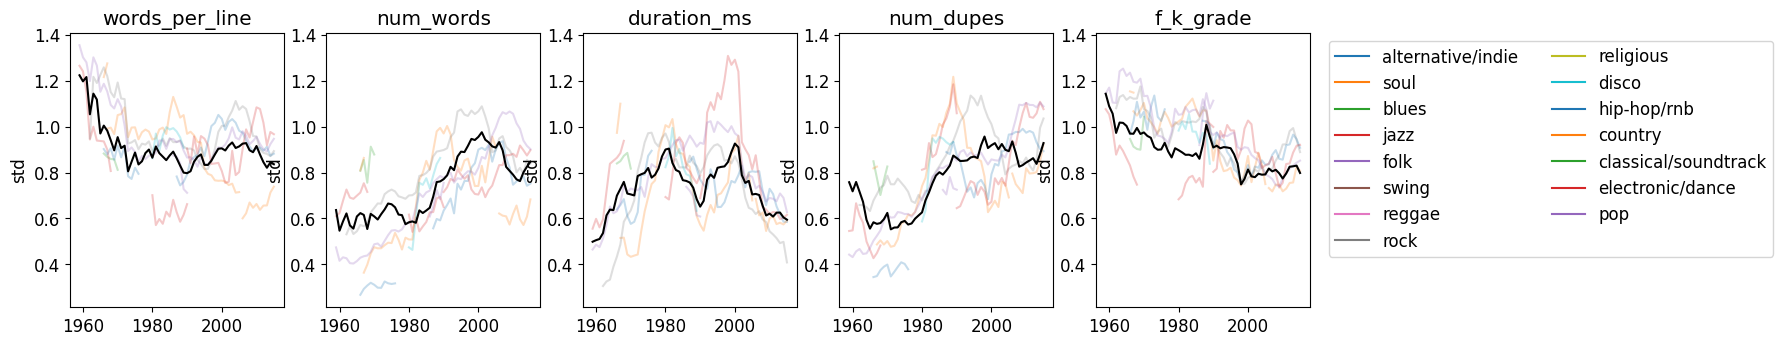

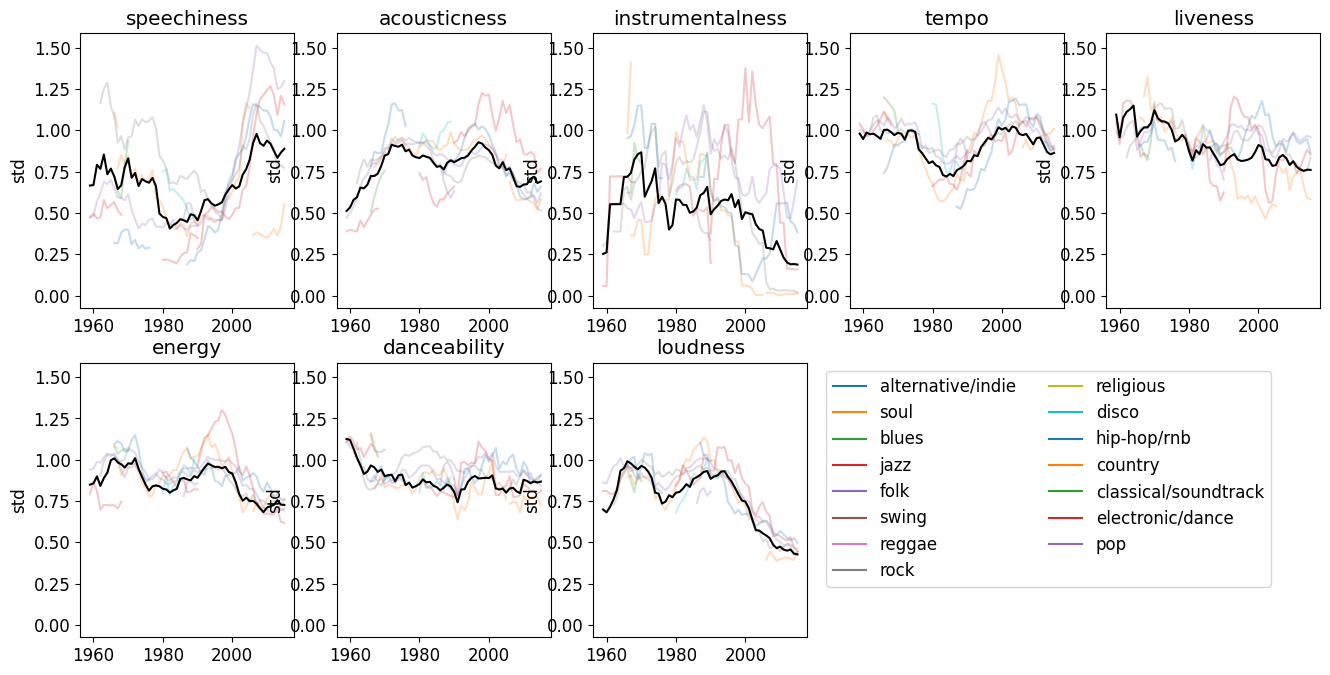

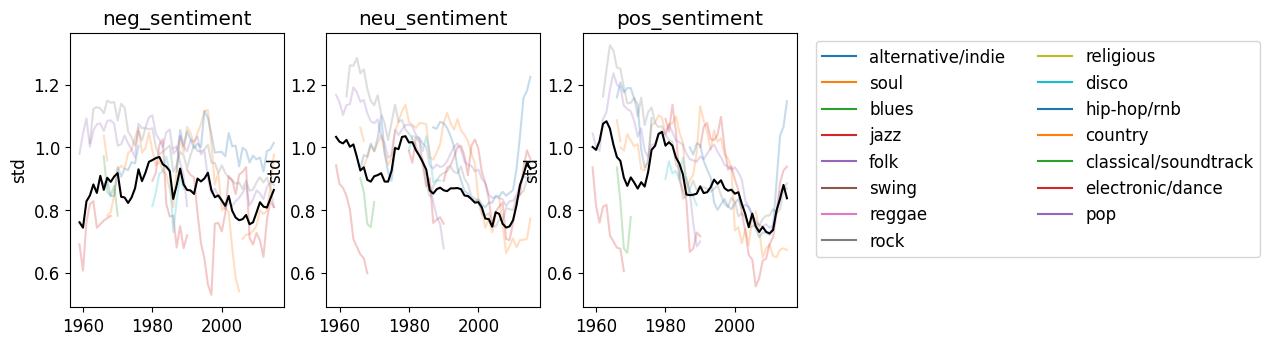

In [135]:
#| output: false
music.plot_numerical_std(vars_words,all_genres, by_genre, legend = True)
music.plot_numerical_std(vars_audio,all_genres, by_genre, legend = True)
music.plot_numerical_std(vars_sentiment,all_genres, by_genre, legend = True)

In [137]:
slopes,pvals = [],[]
for var in vars_words + vars_audio + vars_sentiment:
    for genre in genre_df.genre.unique():
        # print("----")
        # print(var,":",genre)
        mod = smf.ols(formula = f'{var} ~ year', data = genre_df.query(f'genre == "{genre}"'))
        res = mod.fit()
        slopes.append(res.params.values[1])
        pvals.append(res.pvalues.values[1])
        # print("slope = ",res.params.values[1],"| p-value = ",res.pvalues.values[1])
ols_pvals = pd.DataFrame({'slope':slopes,'pval':pvals},
                            index=pd.MultiIndex.from_product([vars_words + vars_audio + vars_sentiment, genre_df.genre.unique()])).reset_index()
ols_pvals.columns = ['variable','genre','slope','pval']

In [138]:
#| output: false
ols_pvals.head()

,variable,genre,slope,pval
0,words_per_line,alternative/indie,0.027929,0.005751
1,words_per_line,soul,0.000683,0.851930
2,words_per_line,blues,-0.000573,0.937644
3,words_per_line,jazz,-0.000098,0.985966
4,words_per_line,folk,-0.005768,0.320312


In [139]:
#| output: false
ols_pvals.query('pval < 0.05').std()

slope    0.027905
pval     0.012695
dtype: float64

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  5.,  6.,  8., 10., 13., 23.,
        32., 13.,  4.,  1.,  3.,  0.,  2.]),
 array([-0.11381074, -0.10342014, -0.09302955, -0.08263896, -0.07224837,
        -0.06185777, -0.05146718, -0.04107659, -0.030686  , -0.0202954 ,
        -0.00990481,  0.00048578,  0.01087637,  0.02126697,  0.03165756,
         0.04204815,  0.05243874,  0.06282934,  0.07321993,  0.08361052,
         0.09400111]),
 <BarContainer object of 20 artists>)

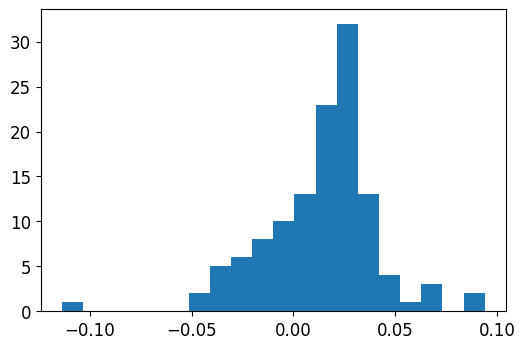

In [140]:
#| output: false
plt.hist(ols_pvals.query('pval < 0.05').slope, bins=20)

In [141]:
slope_std = ols_pvals.query('pval < 0.05').std().values[0]
var_change = pd.DataFrame(index = ols_pvals.groupby('variable').count().index)
var_change['neg_slope'] = ols_pvals.query('slope < 0 and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
var_change['neg_slope_std'] = ols_pvals.query('slope < -@slope_std and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
var_change['pos_slope'] = ols_pvals.query('slope > 0 and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
var_change['pos_slope_std'] = ols_pvals.query('slope > @slope_std and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
var_change = var_change.fillna(0)

In [142]:
#| output: false
.1 / slope_std

3.58357540444746

In [143]:
# var_change = var_change.reset_index()
# var_change['variable'] = var_change['variable'].str.replace("_"," ").replace("num","number of")
var_change['variable'] = ['Acousticness','Danceability','Duration (ms)','Energy','Readability','Instrumentalness','Liveness','Loudness','Negativity','Neutrality','# Duplicate Lines','# Words','Positivity','Speechiness','Tempo','Words per Line']
var_change['order'] = [1,1,2,1,3,1,1,1,4,4,2,2,4,2,1,2]
var_change = var_change.sort_values('order').set_index('variable')

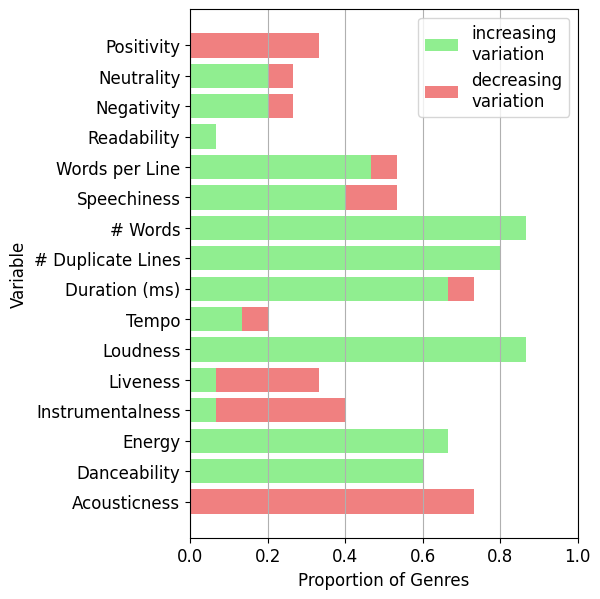

In [144]:
#| include: true
plt.figure(figsize=(5,7))
plt.barh(var_change.index, var_change['pos_slope'], label = 'increasing\nvariation', color = 'lightgreen')
# plt.barh(var_change.index, var_change['pos_slope_std'], label = 'increasing \nvariation\n(std > 1)', color = 'green')
plt.barh(var_change.index, var_change['neg_slope'],left = var_change['pos_slope'], label = 'decreasing\nvariation', color = 'lightcoral')
# plt.barh(var_change.index, var_change['neg_slope_std'],left = var_change['pos_slope'], label = 'decreasing\nvariation\n(std > 1)', color = 'red')
plt.xlim(0,1)
plt.xlabel('Proportion of Genres')
plt.ylabel('Variable')
plt.grid(axis='x')
plt.legend(loc='upper right')
# plt.title('Proportion of genres with significant slopes of standard deviation')
# plt.show()

plt.savefig('slope.png')

*Change of Variability within Genres* <br>
This horizontal stacked bar chart displays the proportion of statistically significant positive and negative slopes of the numerical variables within each genre. Fifteen aggregate genres are included, such as pop, classical/soundtrack, and blues. Most of the slopes are positive.

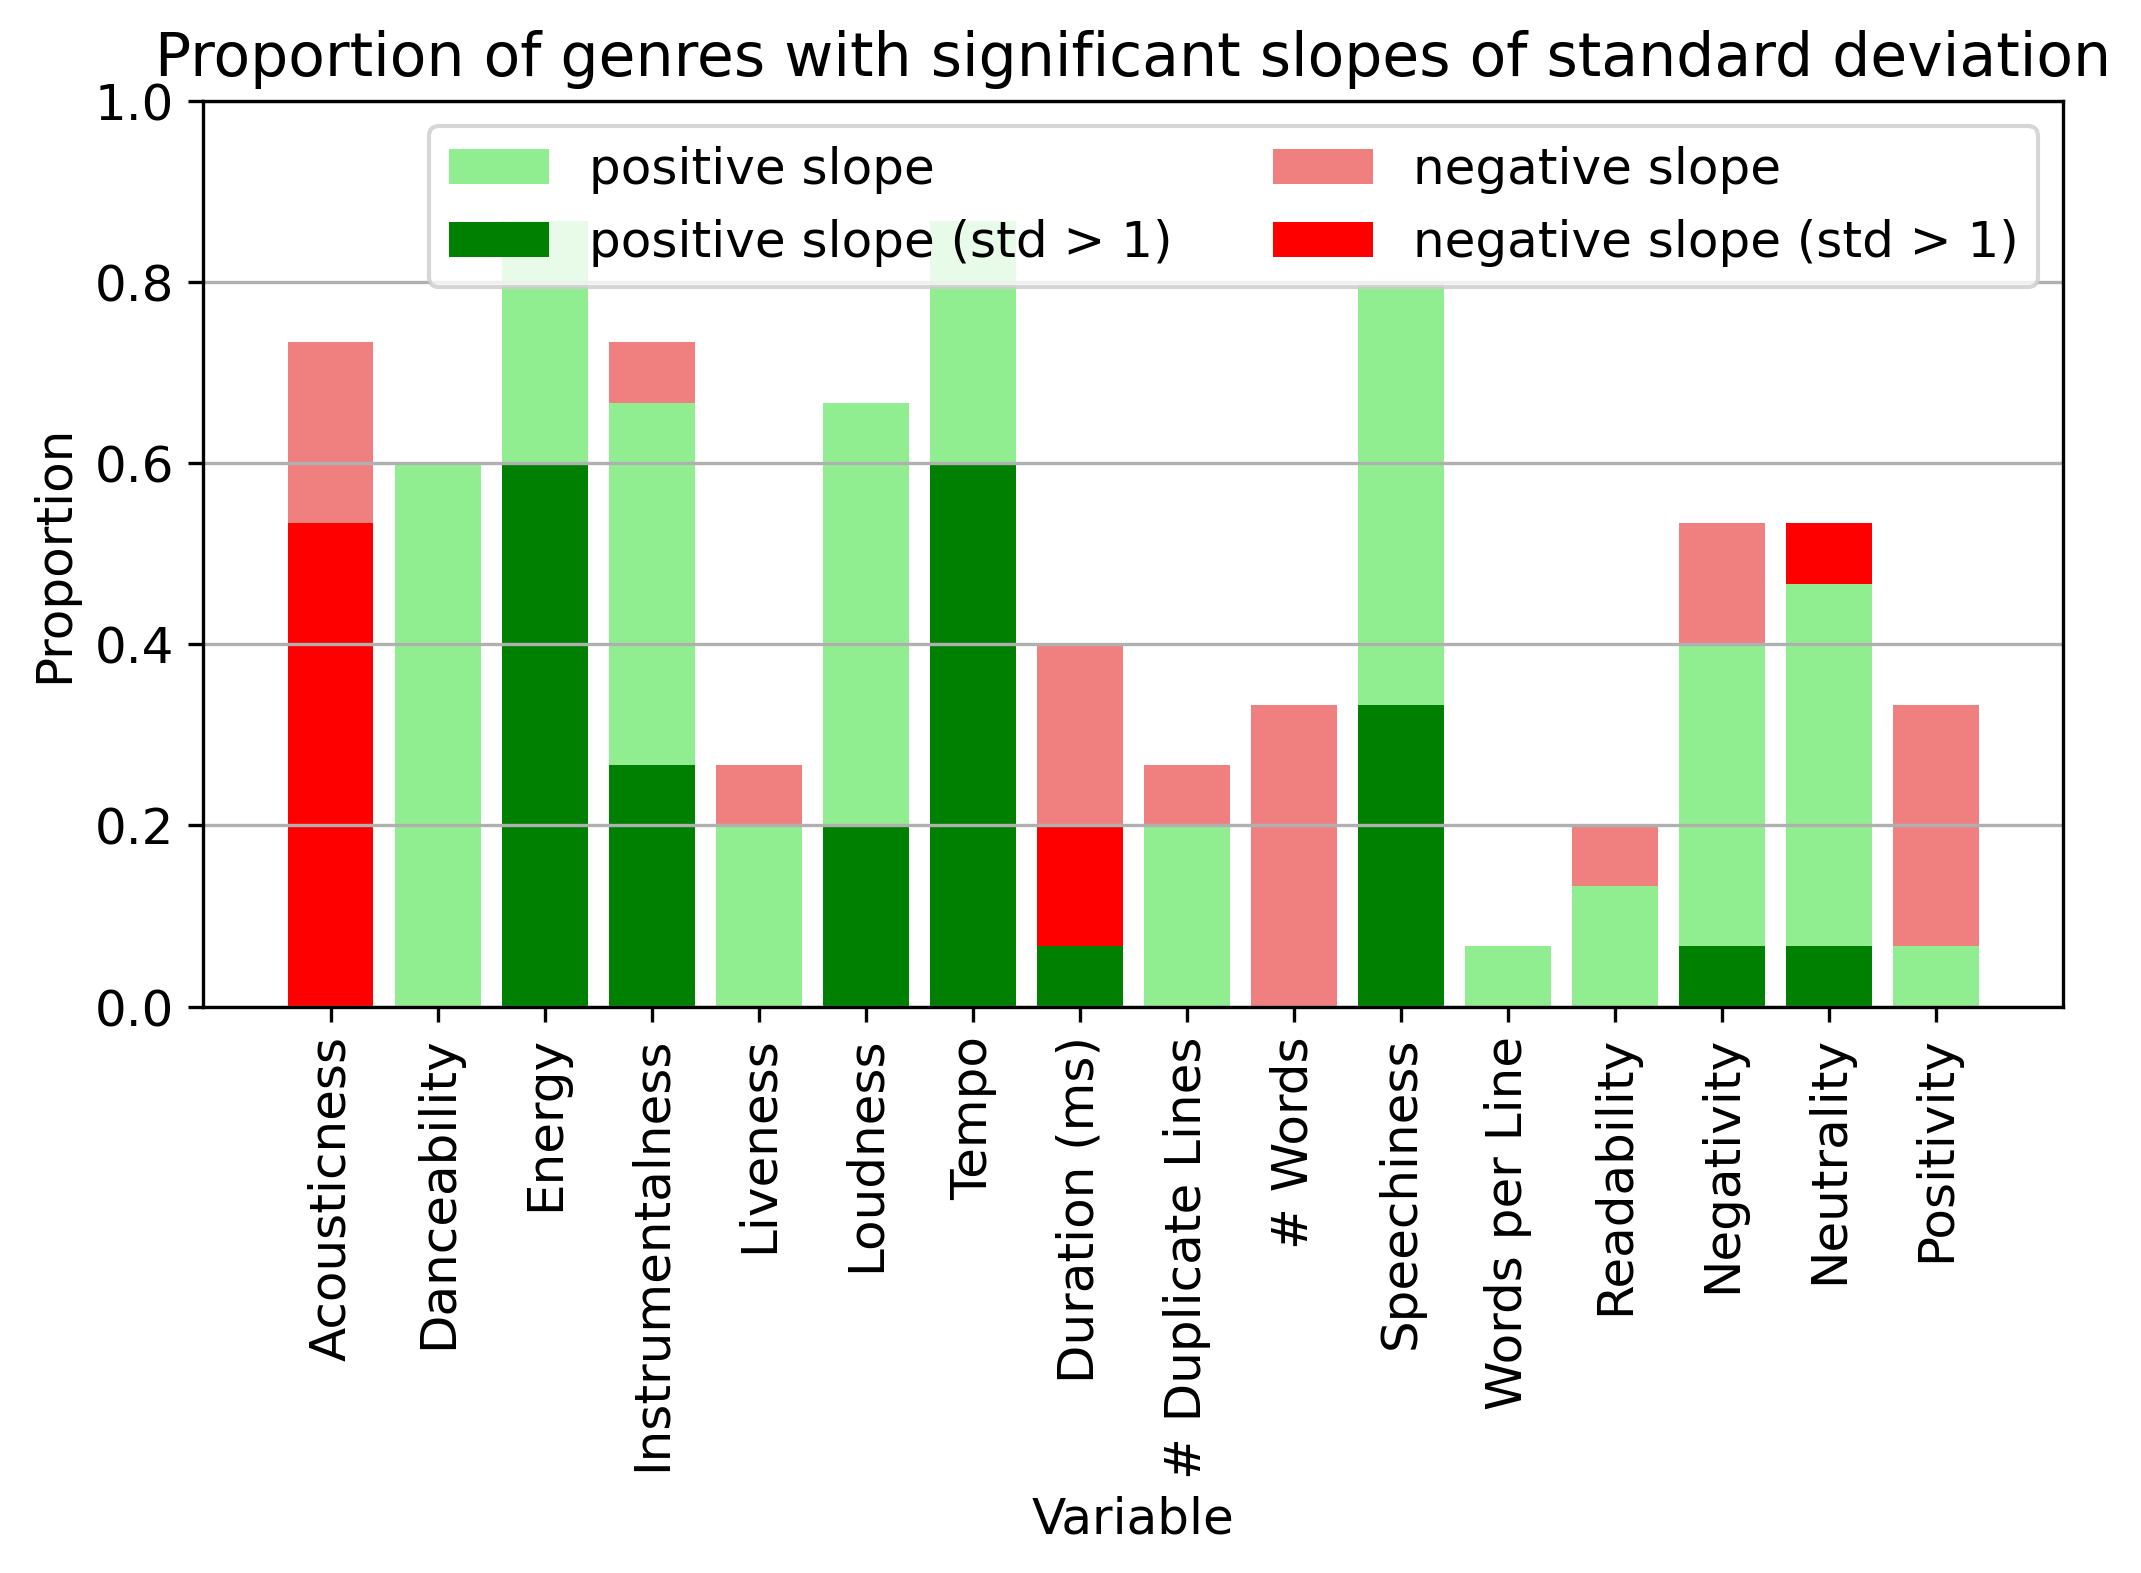

<Figure size 1800x1200 with 0 Axes>

In [115]:
#| output: false
# plot bar chart of variables with significant slopes
plt.figure(figsize=(8,4))
# threshold = 0
# for i in range(4):
#     res = ols_pvals.query('slope > @threshold and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
#     plt.bar(res.index,res.values, label = f'{i} std positive', alpha = 0.25, color='green')
#     threshold += slope_std
# bottom = res.values.copy()
# threshold = 0
# for i in range(4):
#     res = ols_pvals.query('slope < 0 and pval < 0.05').groupby('variable').count()['genre'] / ols_pvals.groupby('variable').count()['genre']
#     plt.bar(res.index, res.values,bottom = bottom, label = 'negative slope', color = 'lightcoral',alpha=0.25)
#     threshold -= slope_std
    # plt.bar(var_change.index, var_change['pos_slope'], label = 'positive', color = 'green',alpha=0.25)

plt.barh(var_change.index, var_change['pos_slope'], label = 'positive slope', color = 'lightgreen')
plt.barh(var_change.index, var_change['pos_slope_std'], label = 'positive slope (std > 1)', color = 'green')
plt.barh(var_change.index, var_change['neg_slope'],bottom = var_change['pos_slope'], label = 'negative slope', color = 'lightcoral')
plt.barh(var_change.index, var_change['neg_slope_std'],bottom = var_change['pos_slope'], label = 'negative slope (std > 1)', color = 'red')
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.xlabel('Variable')
plt.grid(axis='y')
plt.legend(ncol=2)
plt.title('Proportion of genres with significant slopes of standard deviation')
plt.show()

plt.savefig('slope.png')

In favor of Horkheimer's theory, the standard deviation of acousticness within genres has decreased, with 73% of genres having a negative slope with a p-value less than 0.05. However, many variables have actually increased their standard deviation within genres; most notably loudness, number of duplicate lines, number of words, duration, and energy. Additionally, even out of the variables that had a negative slope, most of those are less than a standard deviation away from zero.

While Horkheimer was right that highly successful and different songs had imitators, there does not seem to be evidence that genres became more specific. If we take Horkheimer's understanding of culture to be true, these variables should have become more consistent with genres as genres become more formulaic. While he might argue that these variables actually do not capture the true substance of music, so their standard deviation does not matter, I would disagree. The substance of music is not only in its lyrics, but also how those lyrics are conveyed. Emotion is conveyed through both words and the effects of loudness, repetition, and energy level.